### Idea Exploration Notebook
This notebook is designed to explore ideas related to subsequence DTW and the data that it outputs

In [1]:
#---- Append function directory to the file path ----#
import sys
function_dir = 'C:/Users/angus/Documents/git_repositories/ENGN4350_Honours/subsequence_dtw/'
sys.path.append(function_dir)

#---- Import Modules ----#
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
from scipy.io import loadmat
import os
import _functions.subsequence_dtw_functions as subsequence_dtw_functions
from _functions.subsequence_dtw_functions import analyse_cost
from _functions.determine_ground_truth import calc_ground_truth
from _functions.visualisation import get_video_frame
import folium
import time
from PIL import Image
import io

np.set_printoptions(suppress=True)




##### Data Directories

In [3]:
mat_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Datasets/mat_files/'
compressed_mat_dir = 'F:/Data/Output_Data/data_compression/'
localisation_metric_dir = 'F:/Data/Output_Data/_localisation/sunset1_sunset2/'

filename_dict ={'sunset1' : 'dvs_vpr_2020-04-21-17-03-03.mat',
                'sunset2' : 'dvs_vpr_2020-04-22-17-24-21.mat',
                'night'   : 'dvs_vpr_2020-04-27-18-13-29.mat',
                'daytime' : 'dvs_vpr_2020-04-24-15-12-03.mat',
                'morning' : 'dvs_vpr_2020-04-28-09-14-11.mat',
                'sunrise' : 'dvs_vpr_2020-04-29-06-20-23.mat'}

output_data_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Output Data/subsequence_dtw/'

#--- Colours ----#
green_sea = '#16a085'
emerald = '#2ecc71'
peter_river = '#3498db'
amythest = '#9b59b6'
carrot = '#e67e22'
pomegranate = '#c0392b'

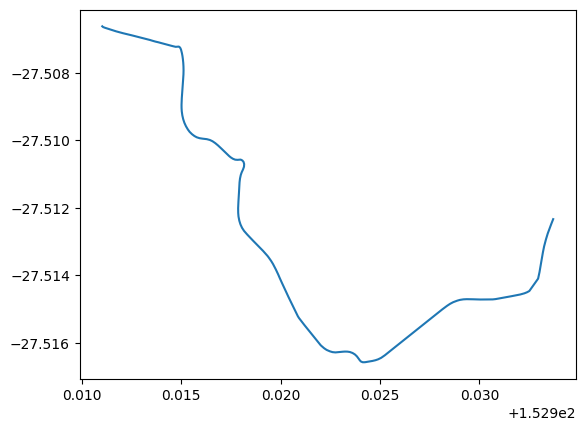

In [10]:
directory = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Datasets/gps_files/_compression_interpolation/pos_44_neg_-32/'
filename = 'sunset1_gps.csv'

gps_data = np.genfromtxt(directory+filename, delimiter=',')

plt.plot(gps_data[:,2], gps_data[:,1])

### Accumulated Cost Analysis

In [3]:
cost_array = np.load('C:/Users/angus/OneDrive - Australian National University/Honours/Data/Output Data/subsequence_dtw/Batch Output/batch_with_cost/sunset1_night_1(1)/accumulated_cost.npy')
# cost_array = np.load('C:/Users/angus/OneDrive - Australian National University/Honours/Data/Output Data/subsequence_dtw/Batch Output/batch_with_cost/sunset1_sunset2_0.25/accumulated_cost.npy')

i = 7
cost = cost_array[i]
alpha = 1
beta = 100

# Analyse the Cost
# min_index, R, nearest_points, filtered_cost = analyse_cost(cost, alpha, beta)
# print(R)
# # Plot
# plt.plot(cost)
# plt.scatter(nearest_points[0,0], cost[nearest_points[0,0].astype(int)], color='green')
# plt.scatter(nearest_points[1:,0], cost[nearest_points[1:,0].astype(int)], color='red')
# plt.show()




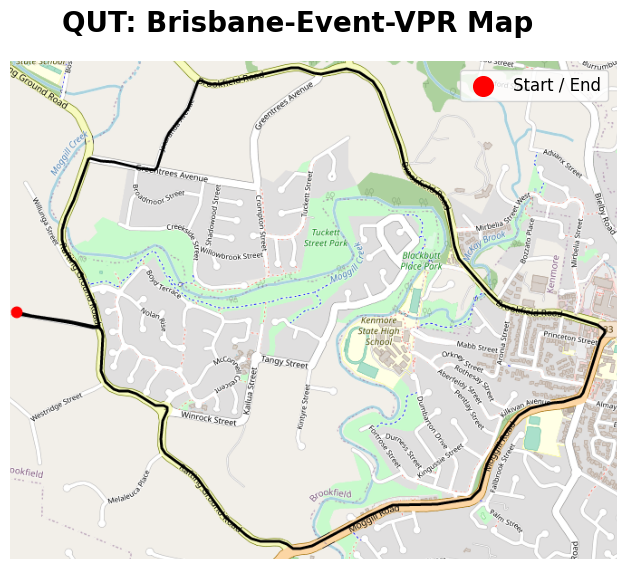

In [17]:
query_filename = 'sunset2'
reference_filename = 'sunset1'

# data_dir = "C:/Users/angus/OneDrive - Australian National University/Honours/Data/Datasets/mat_files/full_datasets/resolution_[2-2]_threshold_750/"
data_dir = "F:/Data/Output_Data/full_dataset/spatial_compression/resolution_[100-100]/pos_44_neg_-32/"


# compression_info = data_dir.split('/')[-2]
# resolution = compression_info.split('_')[1] 
# threshold = compression_info.split('_')[-1]

#---- Load data ----#
query_full = loadmat(data_dir + filename_dict[query_filename])['data']
reference_full = loadmat(data_dir + filename_dict[reference_filename])['data']

query_full[:,0] -= query_full[0,0]
reference_full[:,0] -= reference_full[0,0]


#---- Define Query ----#
query_start = 31
query_end = 31.01
# query_start = 65
# query_end = 66
# query_start = 145
# query_end = 146
# query_start = 212
# query_end = 213 
# query_start = 298
# query_end = 299
# query_start = 377
# query_end = 378
# query_start = 488
# query_end = 489
# query_start = 512
# query_end = 513
# query_start = 615
# query_end = 616


query = subsequence_dtw_functions.select_data_sequence(query_full, query_start, query_end)
reference = subsequence_dtw_functions.select_data_sequence(reference_full, 20, 60)

#---- Perform DTW ----#
start_time = time.time()
C, D, P = subsequence_dtw_functions.subsequence_dtw(query[:,1:3], reference[:,1:3], print_en=0)
dtw_time = time.time()-start_time

#---- Determine Position ----#
a_ast = P[0, 1]
b_ast = P[-1, 1]
reference_time = reference_full[b_ast,0]

reference_path, query_position, estimated_position, distance, ground_truth_index = calc_ground_truth(query_filename, query_end, reference_filename, reference_time)


#---- Define map parameters ----#
map_lat = reference_path[:,0]
map_lon = reference_path[:,1]

min_lat = min(map_lat)
max_lat = max(map_lat)
median_lat = np.median(map_lat)
min_lon = min(map_lon)
max_lon = max(map_lon)
median_lon = np.median(map_lon)

points = np.array([[query_position[0], query_position[1]],
                   [estimated_position[0], estimated_position[1]]])


#---- Mapping ----#
# Create map
m = folium.Map(
    min_zoom=15,
    max_bounds=True,
    location=[median_lat, median_lat],
    zoom_start=15,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon
)

# Create markers
query_marker = folium.CircleMarker(location=[reference_path[0,0], reference_path[0,1]], radius=5, color='red', fill=True, fill_color='red',fill_opacity=1)
query_marker_label = folium.Popup('Start/End', parse_html=True)
# estimate_marker = folium.CircleMarker(location=[estimated_position[0], estimated_position[1]], radius=5, color='blue', fill=True, fill_color='blue', fill_opacity=1)
# estimate_marker_label = folium.Popup('Estimate', parse_html=True)

# Create path
reference_map = folium.PolyLine(locations=reference_path, color='black', weight=3)
# linking_map = folium.PolyLine(locations=points, color='red', weight=3)#, dash_array=[5,5])

# Add features to map
reference_map.add_to(m)
# linking_map.add_to(m)
query_marker.add_to(m)
query_marker.add_child(query_marker_label)
# estimate_marker.add_to(m)
# estimate_marker.add_child(estimate_marker_label)
m

# Convert the map to an image
img_data = m._to_png(1)
img = Image.open(io.BytesIO(img_data))


#------------------#
#---- Plotting ----#
#------------------#
#---- Setup saving ----#
# save_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Figures/_full_dataset_matching/' + f'{reference_filename}_{query_filename}/' + f'{resolution}_{threshold}_({query_start}_{query_end})/'

# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)


# info to print on images


# Compression Resolution: {resolution}
# # Compression Threshold:  {threshold}

# info_string = f'''
# Query: {query_filename}
# Time: {query_start} - {query_end} s
# Length: {query_end-query_start} s ({query.shape[0]} events)

# Reference: {reference_filename}
# Length: {reference_full[-1,0]:.2f} s ({reference_full.shape[0]} events)

# DTW Runtime: {dtw_time:.2f} s 
# Distance Error: {distance:.2f} m

# Actual Position: ({query_position[0]:.3f}, {query_position[1]:.3f})
# Estimated Position: ({estimated_position[0]:.3f}, {estimated_position[1]:.3f})
# '''


#---- Map  ----# 
fig, ax = plt.subplots(1,1, figsize=(8,6))
fig.suptitle("QUT: Brisbane-Event-VPR Map ", fontsize=20, fontweight='bold', ha='center')
fig.subplots_adjust(top=0.95)
fig.tight_layout()
ax.imshow(img)
ax.scatter(0, 0, s=200, label='Start / End', alpha=1, color='red')
ax.set_xlim((350, 1020))
ax.set_ylim((110, 660))
ax.invert_yaxis()
ax.legend(fontsize=12)
ax.axis(False)
# plt.savefig(save_dir+'map.png')
plt.show()

# #---- Map Plot ----# 
# fig, ax = plt.subplots(1,2, figsize=(10,5))
# fig.suptitle("SubDTW: Matching with the Complete Reference", fontsize=16, fontweight='bold', ha='center')
# fig.subplots_adjust(top=0.95, right=0.5)
# fig.tight_layout()
# ax[0].imshow(img)
# ax[0].scatter(0, 0, s=100, label='Query', alpha=1, color='red')
# ax[0].scatter(0, 0, s=100, label='Estimate', alpha=1, color='blue')
# ax[0].legend(fontsize=12)
# ax[0].set_xlim((350, 1020))
# ax[0].set_ylim((110, 660))
# ax[0].invert_yaxis()
# ax[0].axis(False)
# ax[0].text(1.1, 0.7, info_string, transform=ax[0].transAxes, fontsize=10, va='center')
# ax[1].axis('off')
# # plt.savefig(save_dir+'map.png')
# plt.show()

# #---- Video Frames ----#
# frame_query = get_video_frame(query_filename, query_end)
# frame_estimate = get_video_frame(reference_filename, reference_time)

# fig, ax = plt.subplots(1,3,figsize=(16,4))
# fig.suptitle('SubDTW: Comparison of Video Frames', fontsize=16, fontweight='bold')
# fig.subplots_adjust(wspace=0.1, left=0.1, hspace=0.9)
# fig.tight_layout()
# ax[0].imshow(frame_query)
# ax[0].set_title('Query Frame', fontsize=14)
# ax[0].axis('off')
# ax[1].imshow(frame_estimate)
# ax[1].set_title('Matched (Estimate) Frame', fontsize=14)
# ax[1].axis('off')
# ax[1].text(1.05, 0.5, info_string, transform=ax[1].transAxes, fontsize=10, verticalalignment='center')
# ax[2].axis('off')
# # plt.savefig(save_dir+'frame_matching.png')
# plt.show()

# #---- Accumulated Cost ----#
# fig, ax = plt.subplots(figsize=(12,8))
# fig.suptitle('SubDTW: Warping Cost for Complete Reference Matching', fontsize=16, fontweight='bold')
# fig.subplots_adjust(right=0.7, bottom=0.2)
# ax.plot(D[-1,b_ast-10000:b_ast+10000], linewidth=3, zorder=1)
# ax.scatter(b_ast, D[-1,b_ast], color='red', marker='*', s=100, zorder=2, label="Minimum Cost")
# ax.set_xlabel('Reference Index', fontsize=12, fontweight='bold')
# ax.set_ylabel('Query Index', fontsize=12, fontweight='bold')
# ax.text(1.05, 0.5, info_string, transform=ax.transAxes, fontsize=10, verticalalignment='center')
# ax.legend()
# ax.grid(which='both')
# # plt.savefig(save_dir+'accumulated_cost.png')
# plt.show()



In [30]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import os
import folium 
from PIL import Image
import io

filename_dict ={'sunset1' : 'dvs_vpr_2020-04-21-17-03-03.mat',
                'sunset2' : 'dvs_vpr_2020-04-22-17-24-21.mat',
                'night'   : 'dvs_vpr_2020-04-27-18-13-29.mat',
                'daytime' : 'dvs_vpr_2020-04-24-15-12-03.mat',
                'morning' : 'dvs_vpr_2020-04-28-09-14-11.mat',
                'sunrise' : 'dvs_vpr_2020-04-29-06-20-23.mat'}

gps_file_dict = {'sunset1' : 'sunset1_gps.csv',
                 'sunset2' : 'sunset2_gps.csv',
                 'night'   : 'night_gps.csv',
                 'daytime' : 'daytime_gps.csv',
                 'morning' : 'morning_gps.csv',
                 'sunrise' : 'sunrise_gps.csv'}

video_offset = {'sunset1' : 5,
                'sunset2' : -5.5,
                'daytime' : 0,
                'sunrise' : 4.5,
                'morning' : 0,
                'night'   : 2}

mat_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Datasets/mat_files/compressed_data/pos_44_neg_-32/'
gps_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Datasets/gps_files/'


query_name = 'sunset2'
reference_name = 'sunset1'

#---- Load Data ---#
query_dataset = loadmat(mat_dir+filename_dict[query_name])['data']
reference_dataset = loadmat(mat_dir+filename_dict[reference_name])['data']
query_dataset[:,0] -= query_dataset[0,0]
reference_dataset[:,0] -= reference_dataset[0,0]

# GPS csv header order:
#   latiude(deg), longitude(deg), altitude(m), distance travelled(m), speed(m/s), time of day(HHMMSS), elapsed time(s)  
query_gps = np.genfromtxt(gps_dir+gps_file_dict[query_name], delimiter=',')
reference_gps = np.genfromtxt(gps_dir+gps_file_dict[reference_name], delimiter=',')


#---- Define map parameters ----#
map_lat = reference_gps[:,0]
map_lon = query_gps[:,1]

min_lat = min(map_lat)
max_lat = max(map_lat)
median_lat = np.median(map_lat)
min_lon = min(map_lon)
max_lon = max(map_lon)
median_lon = np.median(map_lon)

# points = np.array([[query_position[0], query_position[1]],
#                    [estimated_position[0], estimated_position[1]]])
reference_path = query_gps[:,0:2]

#---- Mapping ----#
# Create map
m = folium.Map(
    min_zoom=15,
    max_bounds=True,
    location=[median_lat, median_lat],
    zoom_start=15,
    min_lat=min_lat,
    max_lat=max_lat,
    min_lon=min_lon,
    max_lon=max_lon
)

index = 23
print(query_gps[index,5])
# Create markers
query_marker = folium.CircleMarker(location=[query_gps[index,0], query_gps[index,1]], radius=5, color='red', fill=True, fill_color='red',fill_opacity=1)
query_marker_label = folium.Popup('Start/End', parse_html=True)
# estimate_marker = folium.CircleMarker(location=[estimated_position[0], estimated_position[1]], radius=5, color='blue', fill=True, fill_color='blue', fill_opacity=1)
# estimate_marker_label = folium.Popup('Estimate', parse_html=True)

# Create path
reference_map = folium.PolyLine(locations=reference_path, color='black', weight=3)
# linking_map = folium.PolyLine(locations=points, color='red', weight=3)#, dash_array=[5,5])

# Add features to map
reference_map.add_to(m)
# linking_map.add_to(m)
query_marker.add_to(m)
query_marker.add_child(query_marker_label)
# estimate_marker.add_to(m)
# estimate_marker.add_child(estimate_marker_label)
m


172458.0


Converting the map to an image


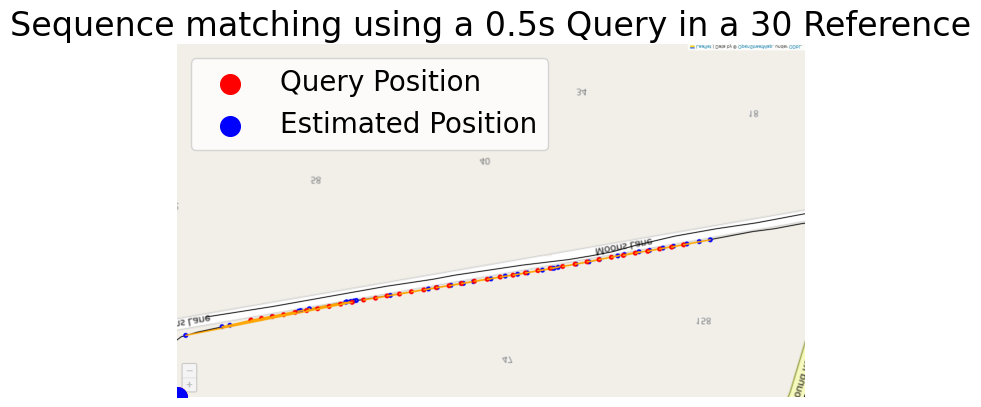

In [19]:
###########################################################################
####                           Import Modules                         #####
###########################################################################
import sys
function_dir = 'C:/Users/angus/Documents/git_repositories/ENGN4350_Honours/subsequence_dtw/'
sys.path.append(function_dir)

#---- Import Modules ----#
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.io import loadmat
import time
import cv2
from PIL import Image
import io
import folium
from tqdm import tqdm

import _functions.subsequence_dtw_functions as subsequence_dtw_functions
import _functions.visualisation as visualisation
import _functions.determine_ground_truth as determine_ground_truth

# data_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Output Data/subsequence_dtw/compression/resolution_[100-100]/dtw_output/data_3/'
# filename = 'batch_data.csv'

data_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Output Data/subsequence_dtw/Batch Output/original_analysis/sunset1_sunset2_0.5(1)/'
filename = 'sunset1_sunset2_0.5_data_filtered.csv'

gps_interp_dir = 'C:/Users/angus/OneDrive - Australian National University/Honours/Data/Datasets/gps_files/_full_data_interp/'
gps_file_dict = {'sunset1' : 'sunset1_gps.csv',
                 'sunset2' : 'sunset2_gps.csv'}

query_name = 'sunset2'
reference_name = 'sunset1'

#---- Load Data ----#
# load DTW batch values 
df = pd.read_csv(data_dir + filename)

query_positions = [df['query_position_0'],df['query_position_1']]
query_positions = np.asarray(query_positions).T
estimated_positions = [df['estimated_position_0'],df['estimated_position_1']]
estimated_positions = np.asarray(estimated_positions).T


# plt.figure()
# plt.scatter(estimated_positions[:,1], estimated_positions[:,0])
# plt.scatter(query_positions[:,1], query_positions[:,0])
# plt.show()

# load the reference map
reference_start_time = 0
reference_end_time = 120
reference_map = np.genfromtxt(gps_interp_dir + gps_file_dict[reference_name], delimiter=',')
reference_path = reference_map[:,1:3]

#---- Plot on Map ----#
#---- Define map parameters ----#
map_lat = reference_path[:50,0]
map_lon = reference_path[:50,1]

min_lat = min(map_lat)
max_lat = max(map_lat)
median_lat = np.median(map_lat)
min_lon = min(map_lon)
max_lon = max(map_lon)
median_lon = np.median(map_lon)

# points = np.array([[query_positions[0], query_positions[1]],
#                    [estimated_positions[0], estimated_positions[1]]])


#---- Mapping ----#
# Create map
zoom = 19
m = folium.Map(min_zoom=zoom, max_bounds=True, location=[median_lat, median_lat], zoom_start=zoom, min_lat=min_lat, max_lat=max_lat, min_lon=min_lon, max_lon=max_lon)

# Create markers

# Create path
reference_map = folium.PolyLine(locations=reference_path, color='black', weight=2, alpha=0.5)

# Add features to map
reference_map.add_to(m)

for i in range(query_positions.shape[0]):
    query_marker = folium.CircleMarker(location=[query_positions[i,0], query_positions[i,1]], radius=4, color='red', fill=True, fill_color='red',fill_opacity=1)
    query_marker_label = folium.Popup('Query', parse_html=True)
    query_marker.add_to(m)
    query_marker.add_child(query_marker_label)

    estimate_marker = folium.CircleMarker(location=[estimated_positions[i,0], estimated_positions[i,1]], radius=4, color='blue', fill=True, fill_color='blue',fill_opacity=1)
    estimate_marker_label = folium.Popup('Query', parse_html=True)
    estimate_marker.add_to(m)
    estimate_marker.add_child(estimate_marker_label)

    points = np.array([[query_positions[i,0], query_positions[i,1]],
                       [estimated_positions[i,0], estimated_positions[i,1]]])
    linking_map = folium.PolyLine(locations=points, color='orange', weight=3)#, dash_array=[5,5])
    linking_map.add_to(m)
m

# Convert the map to an image
print('Converting the map to an image')
img_data = m._to_png(1)
img = Image.open(io.BytesIO(img_data))

fig, ax = plt.subplots(figsize=(7,7))
# fig.subplots_adjust(top=0.898, bottom=0.019,left=0.016,right=0.984,hspace=0.2,wspace=0.2)
# fig.suptitle("SubDTW for Event Sequence Matching", fontweight='bold', fontsize=20)
ax.set_title("Sequence matching using a 0.5s Query in a 30 Reference", fontweight='normal', fontsize=24)
fig.tight_layout()
ax.imshow(img)
ax.scatter(0, 0, s=200, label='Query Position', alpha=1, color='red')
ax.scatter(0, 0, s=200, label='Estimated Position', alpha=1, color='blue')


ax.legend(fontsize=20,loc='upper left')
ax.invert_yaxis()
ax.axis('off')
plt.show()